<a href="https://colab.research.google.com/github/Tanulshn/Python-and-DS-work/blob/main/ARIMA_TSA_Asian_Paint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Basic Package
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

# Warnings 
import warnings
warnings.simplefilter(action='ignore')


### Data Preprocessing

In [ ]:
# Read the data
raw_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Daily Price ARIMA/CSV files/Asian Paint.csv')
raw_data.head(20)

,Date,Value,Price
0,6/3/2019,65.65,1459.25
1,6/4/2019,63.95,1421.50
2,6/5/2019,No Data FOund,No Data FOund
3,6/6/2019,64.27,1428.55
4,6/7/2019,63.81,1418.35
5,6/8/2019,No Data FOund,No Data FOund
6,6/9/2019,No Data FOund,No Data FOund
7,6/10/2019,64.00,1422.60
8,6/11/2019,64.13,1425.50
9,6/12/2019,64.13,1425.45


In [ ]:
raw_data.tail()

,Date,Value,Price
755,6/27/2021,No Data FOund,No Data FOund
756,6/28/2021,93.73,2982.95
757,6/29/2021,94.32,3001.50
758,6/30/2021,94.04,2992.70
759,7/1/2021,94.95,3021.60


In [ ]:
df=raw_data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    760 non-null    object
 1   Value   760 non-null    object
 2   Price   760 non-null    object
dtypes: object(3)
memory usage: 17.9+ KB


In [ ]:
# Change the dtype
for i in (['Value','Price']):
  df[i]=pd.to_numeric(raw_data[i], errors= 'coerce').round(2)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    760 non-null    object 
 1   Value   517 non-null    float64
 2   Price   517 non-null    float64
dtypes: float64(2), object(1)
memory usage: 17.9+ KB


In [ ]:
df.corr()

,Value,Price
Value,1.000000,0.314806
Price,0.314806,1.000000


#### Date-time formatting

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst = False)
df.set_index('Date', inplace=True)
df.isnull().sum()

Value    243
Price    243
dtype: int64

In [ ]:
# Business days time series
data = df.resample('b').last()
data.isnull().sum()

Value    30
Price    30
dtype: int64

In [ ]:
data.fillna(method='bfill', inplace=True)

In [ ]:
data.isnull().sum()

Value    0
Price    0
dtype: int64

In [ ]:
data.shape

(544, 2)

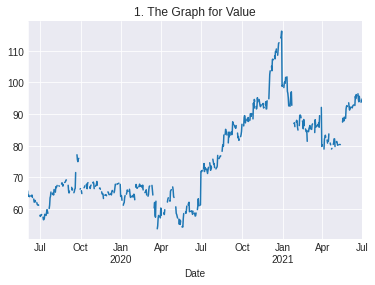

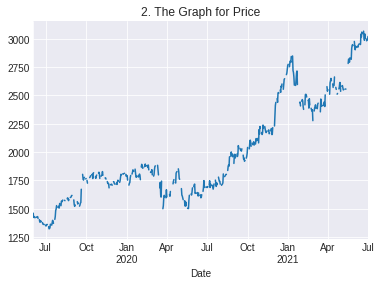

In [ ]:
for col,i in enumerate(['Value','Price']):
  plt.figure(i)
  df[i].plot()
  #plt.axvline(x = Scaled_std_2021.index[-84], color='g')
  #plt.axhline(y =0, color='g')
  plt.title('{}. The Graph for {}'.format(col+1, i))
  plt.show()
  
 


## Test for Stationarity

In [ ]:
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.stattools import adfuller

In [ ]:
# Define a function for Stationarity check

def adfuller_test(series):
  """ Takes the series and tests whether the series is stationary or not 
  by using ADFULLER test.
  """
  result = adfuller(series)
  labels = ['ADF Test stat', 'p-value', '# Lags', '# observations']
  for value, label in zip(result,labels):
    print(label, ': ', str(value))

  if result[1]<=0.05:
    print('Outcome: Strong evidence against the null hypothesis; reject H0; data has no unit root; DATA IS STATIONARY.')
  else:
    print('Outcome: Weak evidence against H0; accept H0, DATA IS NOT STATIONARY') 


In [ ]:
adfuller_test(data['Price'])

ADF Test stat :  0.11265409852541541
p-value :  0.966914503829688
# Lags :  1
# observations :  542
Outcome: Weak evidence against H0; accept H0, DATA IS NOT STATIONARY


Conclusion: The Data is not stationary
We need to induce stationarity to be able to perform forecast through ARIMA

### Induce Stationarity

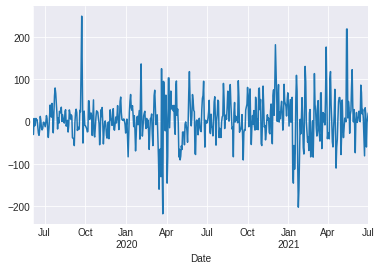

In [ ]:
# First degree differencing
stationary_series = data['Price'].diff(2).dropna()
stationary_series.plot()

In [ ]:
# Check for stationarity
adfuller_test(stationary_series)

ADF Test stat :  -5.370943821882996
p-value :  3.8971617343910624e-06
# Lags :  19
# observations :  522
Outcome: Strong evidence against the null hypothesis; reject H0; data has no unit root; DATA IS STATIONARY.


Now that the snew series is stationary, we can plot ACF and PACF to determine the p and q variables for ARIMA

## Autocorrelation check

In [ ]:
# Create train set
train_size = int(len(data)*0.8)
train_size

435

In [ ]:
import statsmodels.graphics.tsaplots as sgt

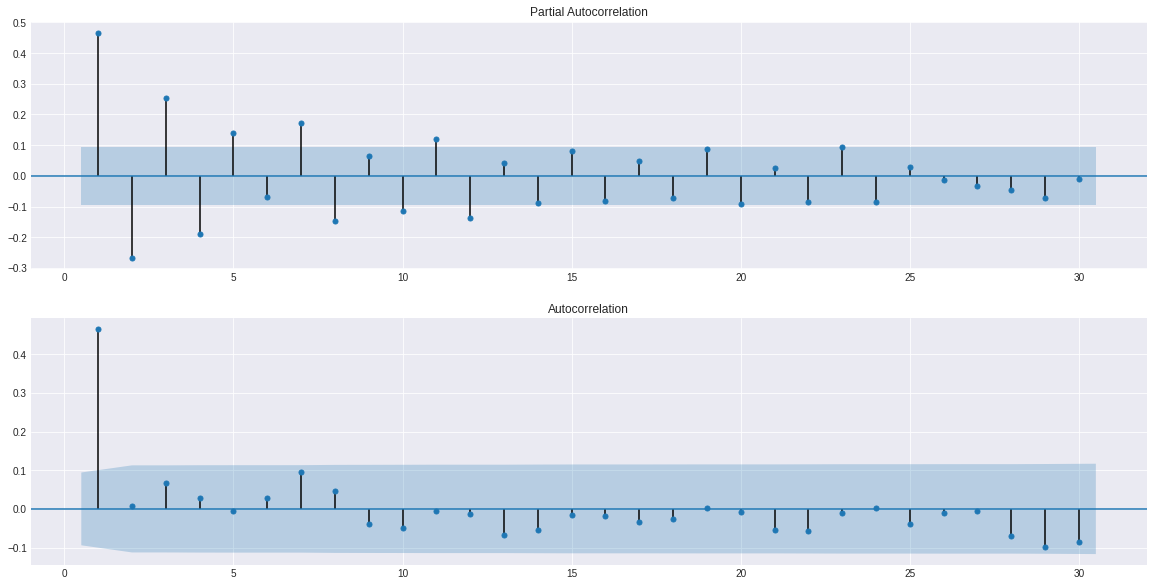

In [ ]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(211)
fig = sgt.plot_pacf(data['Price'][:train_size].diff(2).dropna(), lags=30, ax=ax1,zero= False)

ax2 = fig.add_subplot(212)
fig = sgt.plot_acf(data['Price'][:train_size].diff(2).dropna(), lags=30, ax=ax2, zero= False)



Conclusion:

Value of p: No of lags for AR (PACF Plot): 5

Value of q: No of lags for MA (ACF Plot):  1


## ARIMA model

In [ ]:
# Import package
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [ ]:
# Define a function to call:

def predict_ARIMA(train_data):
  """ The fun will fit ARIMA on the train data and forecast
  """
  model = ARIMA(train_data, order=(5,2,1))
  
  # Fit the model
  try:
    model_fit = model.fit(disp=0)
    #Forecast
    forecast = model_fit.forecast() 
    return forecast[0][0]
  except:
    pass

In [ ]:
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)

# Find the params
model = ARIMA(data['Price'][:train_size], order=(5, 2, 1))
model_fit = model.fit()
print(model_fit.params.round(2))

const             0.01
ar.L1.D2.Price   -0.06
ar.L2.D2.Price   -0.00
ar.L3.D2.Price    0.08
ar.L4.D2.Price   -0.02
ar.L5.D2.Price    0.04
ma.L1.D2.Price   -1.00
dtype: float64


In [ ]:
data['Pred'] = data['Price'].rolling(train_size).apply(predict_ARIMA).round(2)
data['Pred'] = data['Pred'].shift(1)

In [ ]:
data.tail()

,Value,Price,Pred
Date,,,
2021-06-25,94.39,3003.90,3043.38
2021-06-28,93.73,2982.95,3017.31
2021-06-29,94.32,3001.50,2995.80
2021-06-30,94.04,2992.70,3004.54
2021-07-01,94.95,3021.60,3002.07


### ARIMA model evaluation

In [ ]:
def model_performance(actual, predicted):
  """ This function will print the MAE, MSE, RMSE and Mean Absolute percentage error (MAPE)
  This will also plot PACF an residual plot"""

  #Mean Absolute error
  mae = mean_absolute_error(actual, predicted).round(2)
  print('The Mean Absolute Error is: ', mae)
  
  #Mean Squared Error 
  mse = mean_squared_error(actual, predicted).round(2)
  print('The Mean Squared Error is: ', mse)

  # Root Mean Squared Error
  rmse = np.sqrt(mse).round(2)
  print('The RMSE is: ', rmse )

  # Mean Absolute percentage error
  mape = 100*((actual-predicted)/actual).abs().mean()
  print('The Mean Absolute Percentage Error is: ', mape)

  # Residuals
  residuals = actual- predicted
  labels = actual.index
  #fig,(ax1,ax2) = plt.subplot(2,1, figsize=(12,11))

  # Plot Graph
  plt.figure(figsize=(15,10))
  
  plt.subplot(2,1,1)
  plt.plot(actual, color = 'red')
  plt.plot(predicted, color = 'blue' )
  plt.ylabel('Price')
  plt.title('Predicted v/s Actual')

  # Plot PACF
  plt.subplot(2,1,2)
  sgt.plot_acf(residuals, color= 'green')
  plt.xlabel('Lags')
  plt.ylabel('Autocorrelation')
  plt.title('Autocorrelation of Residuals')

  plt.tight_layout()
  plt.show()

The Mean Absolute Error is:  32.4
The Mean Squared Error is:  2043.14
The RMSE is:  45.2
The Mean Absolute Percentage Error is:  1.244115539579242


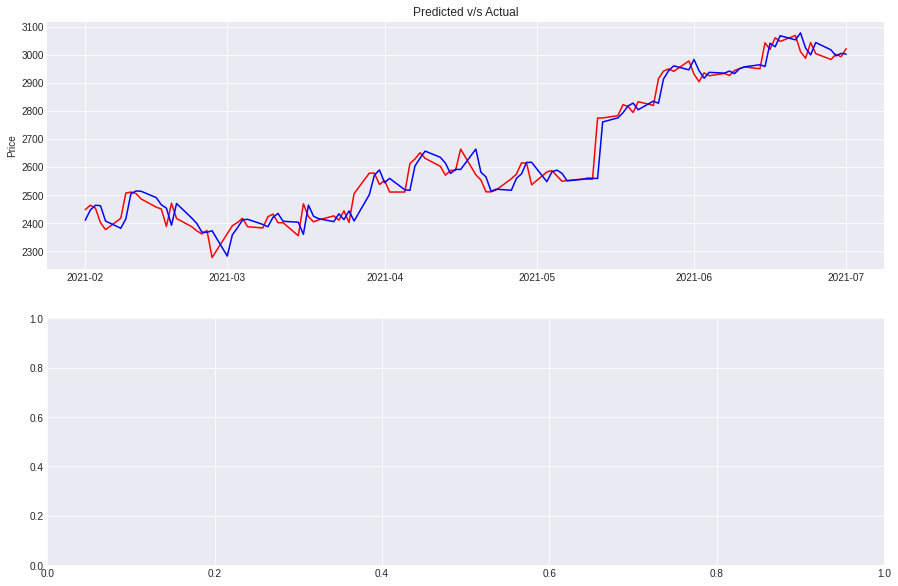

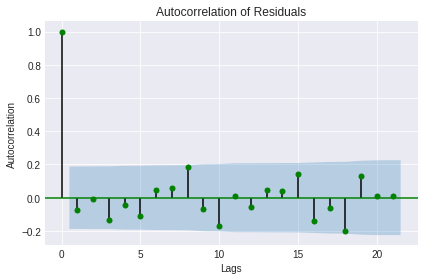

In [ ]:
model_performance(data['Price'].iloc[train_size:],data['Pred'].iloc[train_size:])

### Trade Strategy- Long Short

What are we trying to do in the strategy:
- Create Signal - When the predicted price is higher than previous day actual price, create a signal +1, or -1 if not.
- Signal implies the direction for the returns.
- *Strategy* returns- Creating a hypothetical return (Pred return), in case the position was held throughout the tennure. 

In [ ]:
data['Return'] = data['Price'].pct_change()
data['Position'] = np.where(data['Price'].shift(1) < data['Pred'], 1,-1)

data['Strategy_return'] = data['Return']* data['Position']

data.tail(15)

,Value,Price,Pred,Return,Position,Strategy_return
Date,,,,,,
2021-06-11,92.89,2956.25,2956.74,0.001915,1,0.001915
2021-06-14,92.70,2949.90,2964.26,-0.002148,1,-0.002148
2021-06-15,95.60,3042.20,2957.75,0.031289,1,0.031289
2021-06-16,94.86,3018.70,3040.85,-0.007725,-1,0.007725
2021-06-17,96.16,3060.30,3028.23,0.013781,1,0.013781
2021-06-18,95.75,3047.20,3067.52,-0.004281,1,-0.004281
2021-06-21,96.42,3068.55,3052.82,0.007006,1,0.007006
2021-06-22,94.61,3010.80,3077.53,-0.018820,1,-0.018820
2021-06-23,93.87,2987.35,3023.71,-0.007789,1,-0.007789


In [ ]:
# Define a function to analyse the returns of Strategy returns

def analyse_strategy(return_series):
  """ Takes the Returns column as input and performs few calculations
  Sharpe ratio- Return to risk ratio
  Cumulative return - Month over month return calculated
  Drawdown calculation
  Print statistics
  """
  sharpe_ratio = return_series.mean()/return_series.std()*np.sqrt(252)

  #Cumulative Returns
  cum_return = (return_series+1).cumprod()
  

  print('The Sharpe Ratio is %.2f' % sharpe_ratio)
  print('The cumulative return is %.2f' % (((cum_return[-1])-1)*100) + "%") 
  print('The std dev is: ', return_series.std())
  print( 'The number of days for retrn assessment: ', int(len(return_series)))
  # Plots
  labels = return_series.index
  plt.figure(figsize=(15,10))

  #Plot strategy return
  plt.plot(cum_return, color = 'b')
  plt.title('Cumulative returns', fontsize=14)
  plt.ylabel('Cumulative Return')
  plt.xlabel('Date')

In [ ]:
# Define a function to calcualte return of the stock without strategy
def stock_return(series):
  
  #Cumulative Returns
  cum_return = (series+1).cumprod()

  print('The return of the stock is :',(((cum_return[-1])-1)*100).round(2))

In [ ]:
stock_return(data['Return'].iloc[train_size:])

The return of the stock is : 25.52


The Sharpe Ratio is 2.52
The cumulative return is 33.49%
The std dev is:  0.01765742567358908
 The number of days for retrn assessment:  109


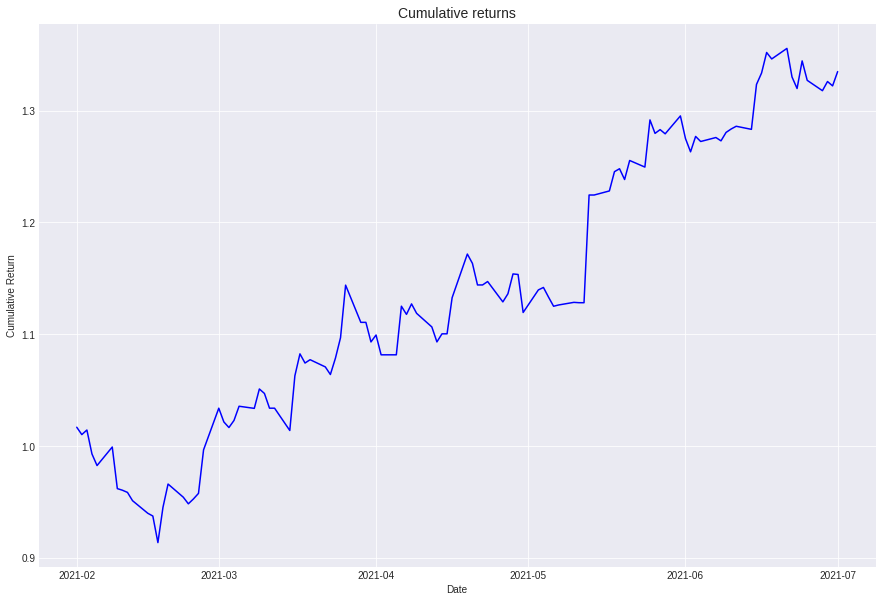

In [ ]:
analyse_strategy(data['Strategy_return'].iloc[train_size:])

### Trade Strategy- Long Only

What are we trying to do in the strategy:
- Create Signal - When the predicted price is higher than previous day actual price, create a signal +1, or 0.
- Signal implies the direction for the returns.
- *Strategy* returns- Creating a hypothetical return (Pred return), in case the position was held throughout the tennure. 

In [ ]:
data['Return'] = data['Price'].pct_change()
data['Position'] = np.where(data['Price'].shift(1) < data['Pred'], 1,0)

data['Strategy_return'] = data['Return']* data['Position']

data.tail(15)

,Value,Price,Pred,Return,Position,Strategy_return
Date,,,,,,
2021-06-11,92.89,2956.25,2956.74,0.001915,1,0.001915
2021-06-14,92.70,2949.90,2964.26,-0.002148,1,-0.002148
2021-06-15,95.60,3042.20,2957.75,0.031289,1,0.031289
2021-06-16,94.86,3018.70,3040.85,-0.007725,0,-0.000000
2021-06-17,96.16,3060.30,3028.23,0.013781,1,0.013781
2021-06-18,95.75,3047.20,3067.52,-0.004281,1,-0.004281
2021-06-21,96.42,3068.55,3052.82,0.007006,1,0.007006
2021-06-22,94.61,3010.80,3077.53,-0.018820,1,-0.018820
2021-06-23,93.87,2987.35,3023.71,-0.007789,1,-0.007789


In [ ]:
stock_return(data['Return'].iloc[train_size:])

The return of the stock is : 25.52


The Sharpe Ratio is 2.54
The cumulative return is 29.90%
The std dev is:  0.01573889479834617
 The number of days for retrn assessment:  109


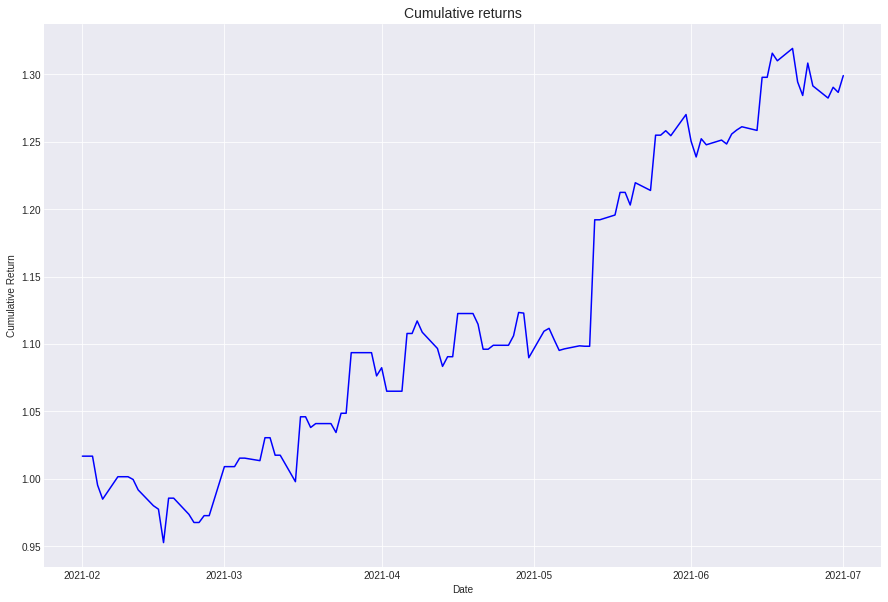

In [ ]:
analyse_strategy(data['Strategy_return'].iloc[train_size:])

### Calculate Volatility
To calculate the volatility, we measure the std dev of the log of returns.

Since the volatility measures the fluctuation in time, a common mistake is that it is calculated over the price. However, it should be calculated as the dispersion of the log of returns.

This is because the distribution of price is unknown and we are taking standard deviation as a measure of risk. To be sure that the standard deviation is accurate and meaningful, an assumption has to be made that the underlying data follows a normal distribution. Hence the volatility is calculated over the log of returns.

#### Daily Volatility

In [ ]:
# Daily Volatility

# Compute the Log returns 
data['log_R'] = np.log(data['Price']/data['Price'].shift(1))

# Compute volatility using the pandas rolling std dev function 
data['Daily_Volatility'] = data['log_R'].rolling(window=20).std()*100

data.tail()

,Value,Price,Pred,Return,Position,Strategy_return,log_R,Daily_Volatility
Date,,,,,,,,
2021-05-25,75.86,1450.95,1448.03,0.005335,1,0.005335,0.005321,1.382351
2021-05-26,77.01,1472.90,1454.78,0.015128,1,0.015128,0.015015,1.402167
2021-05-27,77.53,1482.85,1478.47,0.006755,1,0.006755,0.006733,1.351637
2021-05-28,77.28,1478.10,1487.41,-0.003203,1,-0.003203,-0.003208,1.298660
2021-05-31,76.74,1467.70,1482.82,-0.007036,1,-0.007036,-0.007061,1.324303


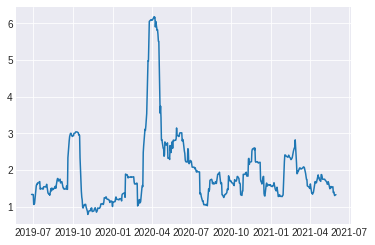

In [ ]:
plt.plot(data['Daily_Volatility'])

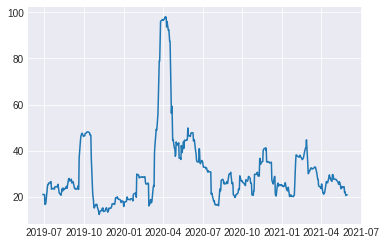

In [ ]:
# Convert daily volatility to annual volatility
data['Annual_Volatility'] = data['Daily_Volatility']* np.sqrt(252)

plt.plot(data['Annual_Volatility'])